<a href="https://colab.research.google.com/github/nagpalpranay/image_classifier/blob/main/classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [2]:
from fastbook import *
from fastai.vision.widgets import *

## First, get the images from bing search

In [3]:
import os
key = os.environ.get('AZURE_SEARCH_KEY', '9c48cbf8d396475fb4741f041fd985ef')

In [4]:
# search_images_bing returns a slightly modified fastai list of Azure's ImageObject class, size of list=150
results = search_images_bing(key, 'raven')
# get the url of the images in the list
ims = results.attrgot('contentUrl')
len(ims)

150

### Display one of the images found

In [5]:
dest = 'images/raven.jpg'
download_url(ims[0],dest)

Path('images/raven.jpg')

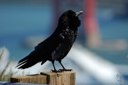

In [6]:
im = Image.open(dest)
im.to_thumb(128,128)

## Going to train a Neural Network to classify between ravens, crows, and blackbirds.
#### Get images for each category into different folders

In [7]:
bird_types = 'raven', 'crow', 'blackbird'
path = Path('birds')

In [8]:
download_images

<function fastai.vision.utils.download_images>

In [9]:
if not path.exists():
    path.mkdir()
    for b in bird_types:
        dest = (path/b)
        dest.mkdir(exist_ok=True) # exist_ok=True => no error if dir already exists
        results = search_images_bing(key, f'{b}')
        download_images(dest, urls=results.attrgot('contentUrl'))

In [10]:
get_image_files

<function fastai.data.transforms.get_image_files>

In [11]:
allImages = get_image_files(path)

In [12]:
verify_images # find images that cannot be opened

<function fastai.vision.utils.verify_images>

In [13]:
failed = verify_images(allImages)

In [14]:
# We find no failed images. If we did we would unlink them
failed.map(Path.unlink);

## The next step is to load these images along with their labels, split the dataset into train, validation for the NN

In [15]:
DataBlock # build a dataset or dataloader

fastai.data.block.DataBlock

In [16]:
# label item with parent folder name
parent_label

<function fastai.data.transforms.parent_label>

In [17]:
RandomSplitter

<function fastai.data.transforms.RandomSplitter>

In [18]:
birds = DataBlock(blocks=(ImageBlock, CategoryBlock), get_items=get_image_files, 
                  splitter=RandomSplitter(valid_pct=0.2, seed=35), 
                  get_y=parent_label, item_tfms=Resize(128))

In [19]:
dls = birds.dataloaders(path)

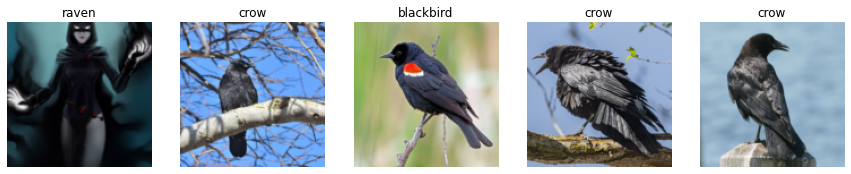

In [20]:
dls.valid.show_batch(max_n=5, nrows=1)

### Resizing and cropping images to transform for learning

In [21]:
RandomResizedCrop # Picks a random scaled crop of an image and resize it to size

fastai.vision.augment.RandomResizedCrop

In [22]:
birds = birds.new(item_tfms=RandomResizedCrop(224, min_scale=0.5))

In [23]:
dls = birds.dataloaders(path)

In [24]:
cnn_learner

<function fastai.vision.learner.cnn_learner>

In [25]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.700690,0.923386,0.325581,00:16


epoch,train_loss,valid_loss,error_rate,time
0,1.033952,0.855626,0.325581,00:25
1,0.770338,0.914548,0.302326,00:19
2,0.636402,0.905316,0.325581,00:16
3,0.543058,0.887581,0.325581,00:16


#### The error rate is high so we check the confusion matrix and the dataset to see if it needs cleaning.

In [26]:
doc(ClassificationInterpretation.from_learner)

,Type,Default
learn,,
ds_idx,int,1
dl,NoneType,``
act,NoneType,``


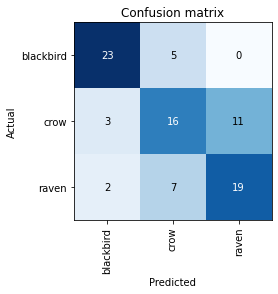

In [27]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

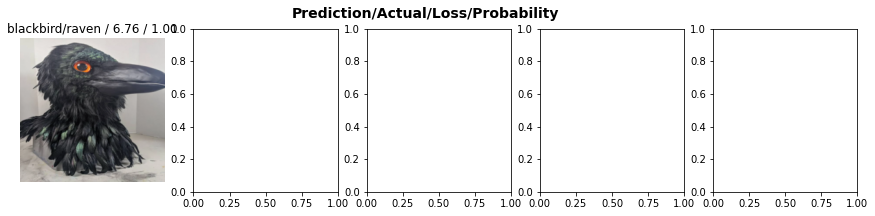

In [28]:
interp.plot_top_losses(5, nrows=1)

In [29]:
doc(ImageClassifierCleaner)

In [30]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [31]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()

In [32]:
learn.export()

In [33]:
# checking the exported model file exists
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [34]:
btn_upload = widgets.FileUpload()

In [35]:
btn_run = widgets.Button(description='Classify')

In [36]:
learn_inf = load_learner(path/'export.pkl')
out_pl = widgets.Output()
lbl_pred = widgets.Label()

def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [37]:
VBox([widgets.Label('Select your black bird!'), 
      btn_upload, btn_run, out_pl, lbl_pred])